In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

In [4]:
data_path = '../data/' # Where your customer and performance data located
output_path = 'TO BE FILLED IN' # Where do you want to output the final dataset
filename = 'TO BE FILLED IN' # What do you want to name the output dataset 

## Data Loading & Preprocessing

In [12]:
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')

### 1. Customer Dataset

In [5]:
Customer_old = pd.read_csv(data_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_path + 'Customer_Data_Request_20191217.csv')

In [6]:
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)
# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

In [11]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date
0,100001115,1000,02/24/2014,6880.0,230.0,58229,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,Employed,NaN
1,100001120,1000,02/24/2014,6520.0,362.0,109245,Repeat Buyer,94 Brentwood Ln,NaN,Valley Stream,NY,11581,Employed,NaN
2,100001141,1000,02/25/2014,10290.0,337.0,127226,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,Employed,NaN
3,100001158,1000,02/24/2014,5190.0,419.0,49375,Repeat Buyer,1036 Braddish Ave,NaN,Baltimore,MD,21216,Employed,NaN
4,100001169,1000,02/24/2014,7500.0,448.0,69460,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,Employed,NaN


In [7]:
# Check Missing Values
Customer.isnull().sum(axis=0)

Unique_Customer_ID              0
Unique_Company_ID               0
Enrollment_Date                 0
Assigned_Spending_Limit         0
Customer_Tenure               110
Customer_Salary             67538
Prior_Customer_Flag             0
Street1                        71
Street2                    483722
City                           68
State                           1
Zip                             6
Status                        308
Term_Date                  491485
dtype: int64

In [8]:
# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.'
# Assigned_Spending_Limit has 0
# Customer_Tenure has NaN
# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (~Customer['Customer_Salary'].isin([0, '.'])) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]



In [7]:
# Formating conversion
Customer['Street1'] = Customer['Street1'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Street2'] = Customer['Street2'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['City'] = Customer['City'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Status'] = Customer['Status'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer.loc[Customer['Customer_Salary']=='.','Customer_Salary']=np.nan
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')
Customer.loc[Customer['Term_Date']=='.','Term_Date'] = np.nan
Customer['Term_Date'] = pd.to_datetime(Customer['Term_Date'].astype(str), format='%m/%d/%Y')

In [9]:
#  # Formating conversion
# Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
# Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')

In [38]:
Customer.dtypes

Unique_Customer_ID                  int64
Unique_Company_ID                   int64
Enrollment_Date            datetime64[ns]
Assigned_Spending_Limit           float64
Customer_Tenure                   float64
Customer_Salary                   float64
Prior_Customer_Flag                object
Street1                            object
Street2                            object
City                               object
State                              object
Zip                                object
Status                             object
Term_Date                          object
dtype: object

### 2. Performance Dataset

In [8]:
### 2. Performance Dataset

Perf_11 = pd.read_csv('../data/Performance_Data_Request_20191217.csv')
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns = {' Unique_Order_ID':'Unique_Order_ID','Order_date':'Order_Date'},inplace = True)
Perf.rename(columns = {'items_ordered':'Items_Ordered','EMPSTATUS':'Customer_Status'},inplace = True)
Perf = Perf.append(Perf_11, ignore_index=True)

# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID','Year_and_Month'],ascending = [False,True])

# Create new column - YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

Perf.loc[Perf['Date_account_went_delinquent']=='.','Date_account_went_delinquent'] = np.nan
Perf['Date_account_went_delinquent'] = pd.to_datetime(Perf['Date_account_went_delinquent'].astype(str), format='%m/%d/%Y')


# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
# Create a flag Ever_Bad to distinguish first time bad and non-first time bad 
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']


# Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

# Some cleaning here
Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=np.nan
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount']!=0)]

Perf.loc[Perf['Payments_Due']=='.','Payments_Due']=np.nan
Perf['Payments_Due'] = Perf['Payments_Due'].astype(float)


Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [10]:
# Perf = pd.read_csv(data_path + 'Performance_Data_Request_20191204.csv')
# Perf_11 = pd.read_csv(data_path + 'Performance_Data_Request_20191217.csv')

In [11]:
# # Deal with the column name mismatching issue before appending the 2 dataframes together
# Perf_11.rename(columns = {' Unique_Order_ID':'Unique_Order_ID','Order_date':'Order_Date'},inplace = True)
# Perf.rename(columns = {'items_ordered':'Items_Ordered','EMPSTATUS':'Customer_Status'},inplace = True)
# Perf = Perf.append(Perf_11, ignore_index=True)

In [12]:
# # Make sure the data order is aligned with OrderID & Y-M
# Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
# Perf = Perf.sort_values(['Unique_Order_ID','Year_and_Month'],ascending = [False,True])

# # Create new column - YQ and Year
# Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
# Perf['Year'] = Perf['YQ'].dt.year

# # Assign Payment Order as a new column
# Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# # Treat 151+ ad CO as BAD
# Perf['Bad']=0
# Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
# # Create a flag Ever_Bad to distinguish first time bad and non-first time bad 
# Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# # Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
# Perf['2os_loss'] = 0
# Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
# Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']


# # Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

In [13]:
# # Some cleaning here
# Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=np.nan
# Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

# Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount']!=0)]

In [14]:
# Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [19]:
Customer.groupby('Unique_Company_ID').agg({'Unique_Customer_ID': 'count', 'Assigned_Spending_Limit': 'mean',
                                      'Customer_Salary': 'mean', 'Customer_Tenure': 'mean', 'Term_Date': 'nunique'}).sort_values('Unique_Customer_ID', ascending=False).reset_index().round(1).head(20)

,Unique_Company_ID,Unique_Customer_ID,Assigned_Spending_Limit,Customer_Salary,Customer_Tenure,Term_Date
0,2049,72121,5467.3,56580.0,165.0,18
1,2302,45217,1960.1,32033.1,100.6,557
2,2311,20778,5239.7,41965.2,104.2,263
3,2149,17658,3734.3,38373.9,115.9,403
4,2250,16119,4787.6,45211.6,102.1,316
5,2496,11972,2250.8,436748.2,83.9,104
6,2238,11227,6921.8,51731.2,153.1,486
7,2422,10296,5315.8,41727.5,112.2,123
8,2047,10073,6730.7,60904.5,193.6,4
9,2191,9817,4839.5,35896.6,132.0,235


## 1. Fed

In [10]:
df_17 = Perf[Perf['Year']>=2017]
# df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [22]:
fed = df_17[df_17['Unique_Company_ID']==2049]

In [27]:
rest = df_17[df_17['Unique_Company_ID']!=2049]

In [ ]:
# Order_Amount, Assigned_Spending_Limit, Tenure_at_time_of_Order, Customer_Salary, Status, when turns bad

In [28]:
list(df_17)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'Items_Ordered',
 'Year_and_Month',
 'Customer_Status',
 'Order_Date',
 'YQ',
 'Year',
 'Payment_Order',
 'Bad',
 'Ever_Bad',
 '2os_loss',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date']

In [23]:
df_17.shape

(22428705, 44)

In [24]:
fed.shape

(2357831, 44)

In [58]:
fed_bad = fed[(fed['Bad']==1) & (fed['Ever_Bad']<=1)]
# fed_good = fed[~fed['Unique_Customer_ID'].isin(fed_bad['Unique_Order_ID'].tolist())]
fed_good = fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)

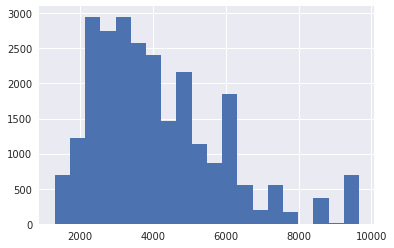

In [32]:
fed_bad['Assigned_Spending_Limit'].hist(bins = 20)

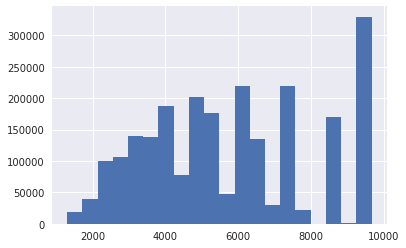

In [33]:
fed_good['Assigned_Spending_Limit'].hist(bins = 20)

In [59]:
fed_good[fed_good['Bad']==1]

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date


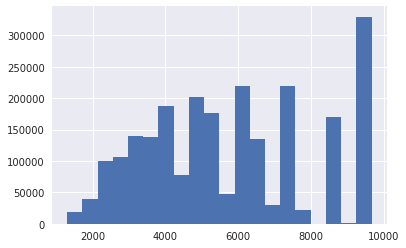

In [25]:
# 63 oders with 0 spending limit, 13 of them CO
fed['Assigned_Spending_Limit'].hist(bins = 20)

In [26]:
fed['Assigned_Spending_Limit'].describe()

count    2.357831e+06
mean     5.814333e+03
std      2.319236e+03
min      1.300000e+03
25%      3.990000e+03
50%      5.400000e+03
75%      7.200000e+03
max      9.660000e+03
Name: Assigned_Spending_Limit, dtype: float64

In [35]:
# fed_bad.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean').plot(title='Avg Assigned Spending Limit', figsize=(16, 8))

# fed_good.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean').plot(title='Avg Assigned Spending Limit', figsize=(16, 8))

# plt.show()

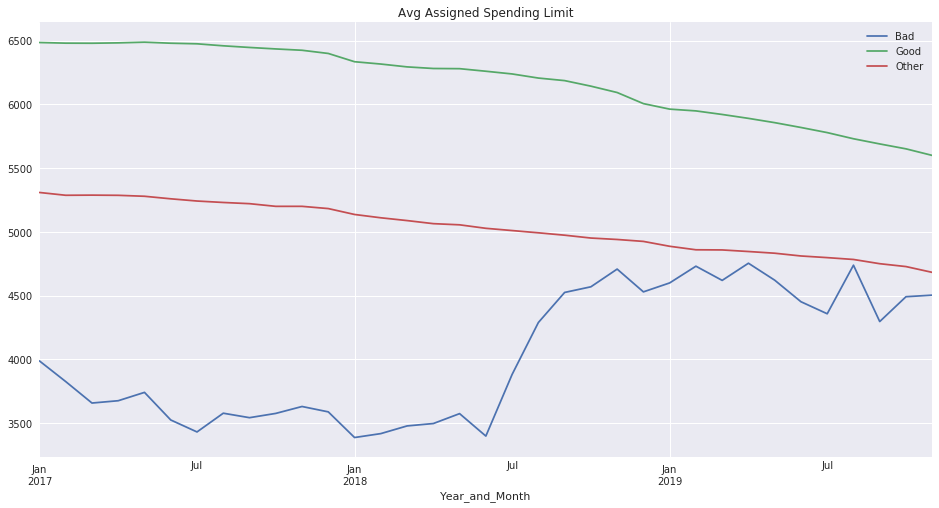

In [86]:
ax = fed_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8))
fed_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good','Other'])
plt.show()

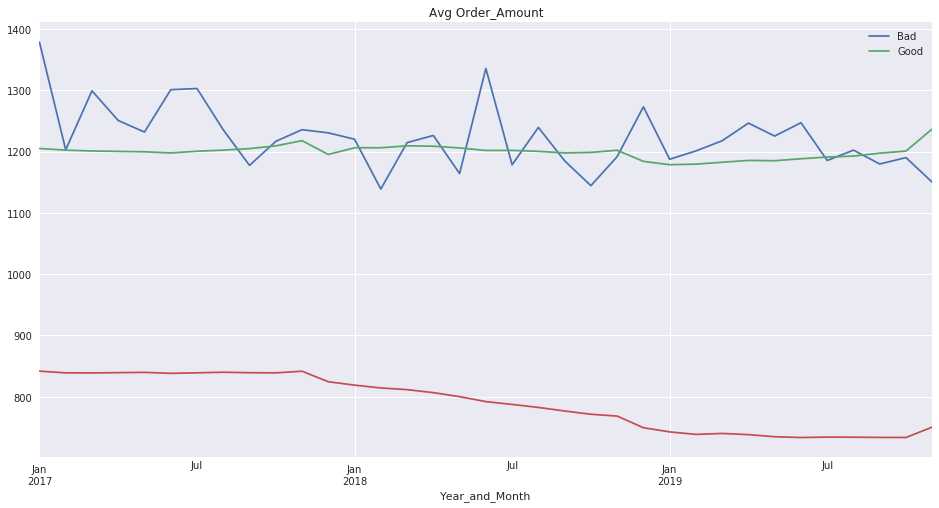

In [88]:
ax = fed_bad.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8))
fed_good.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

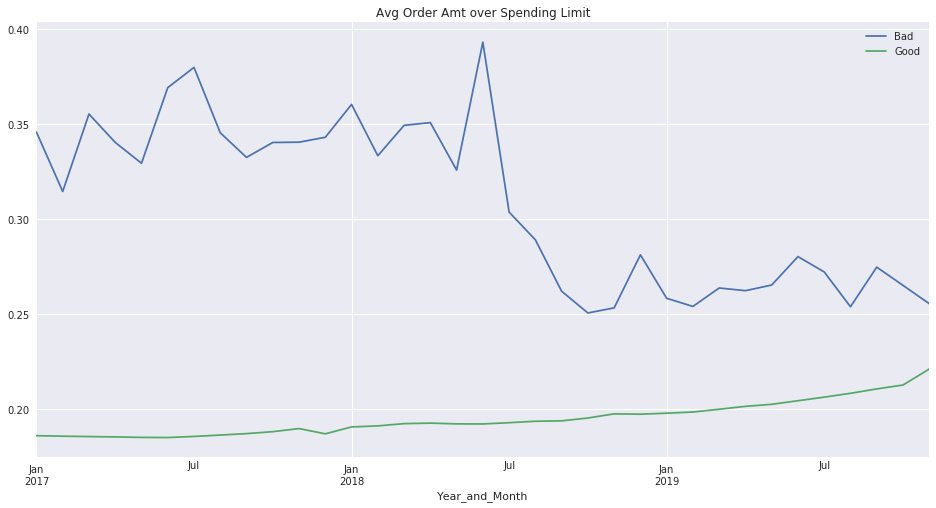

In [62]:
ax = (fed_bad.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/fed_bad.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot()

(fed_good.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/fed_good.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(title='Avg Order Amt over Spending Limit', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

In [ ]:
# fed.loc[fed['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan
# fed['Tenure_at_time_of_Order'] = fed['Tenure_at_time_of_Order'].astype(float)

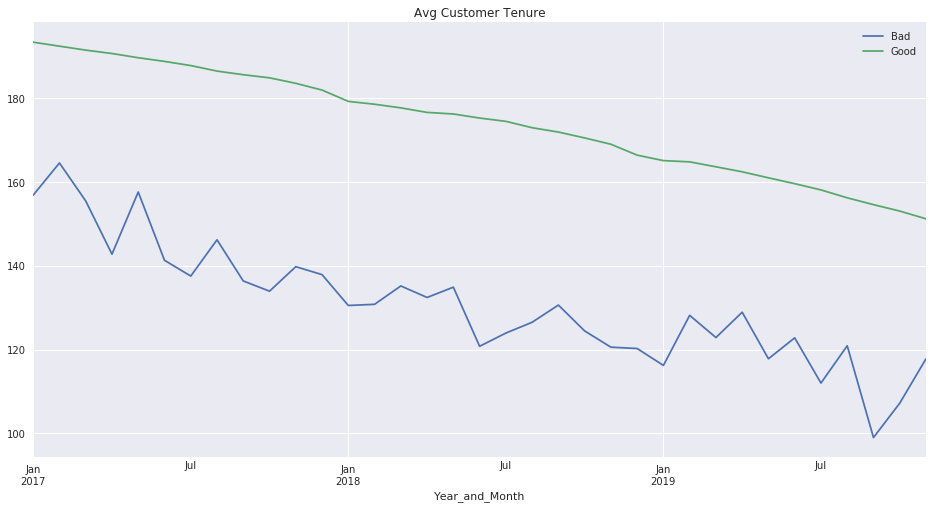

In [70]:
ax = fed_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot()
fed_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(title='Avg Customer Tenure', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

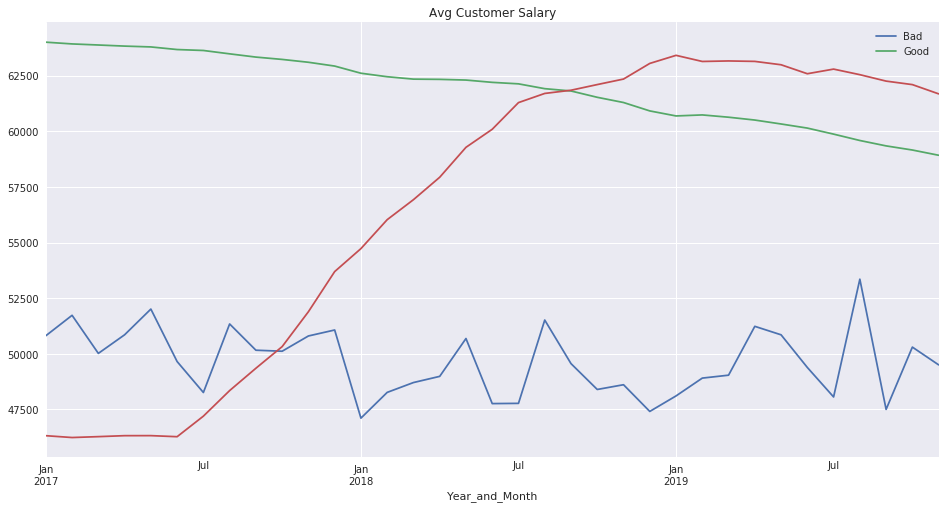

In [87]:
ax = fed_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot()
fed_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(title='Avg Customer Salary', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(title='Avg Customer Salary', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

In [ ]:
(fed[fed['Assigned_Spending_Limit']>0].pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/fed.pivot_table(values='Customer_Salary', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(title='Avg Spending Limit over Salary', figsize=(16, 8))
plt.show()

In [72]:
fed_bad['Status'].value_counts()

Employed       21044
Direct Bill     4423
Deceased          79
Terminated         2
Name: Status, dtype: int64

In [83]:
fed_bad.groupby('Unique_Customer_ID').agg({'Unique_Order_ID':'nunique'}).reset_index().groupby('Unique_Customer_ID').filter(lambda x: x['Unique_Order_ID']>1).shape[0]#.hist(bins=20)

5877

In [84]:
fed_bad.groupby('Unique_Customer_ID').agg({'Unique_Order_ID':'nunique'}).shape[0]

10162

In [92]:
avg_order = rest.pivot_table(values='Order_Amount', columns='Unique_Company_ID',
                             index='Year_and_Month', aggfunc='mean').reset_index().rename_axis(None, axis=1)

In [96]:
avg_order.iloc[:,1:].mean()

1000.0    1120.362513
1200.0    1279.655282
1302.0    1060.838611
1500.0     877.009647
2047.0    1306.598982
2048.0     884.018057
2075.0     793.540111
2095.0     690.618667
2149.0     945.962428
2157.0     702.670000
2158.0    1259.400834
2160.0     913.006692
2161.0     714.095339
2162.0     865.924237
2163.0     747.683930
2164.0     702.133045
2167.0    1293.822735
2168.0    1250.431111
2171.0     921.723122
2173.0    1110.650626
2174.0     851.744960
2175.0    1326.596344
2179.0    1375.213688
2180.0     848.153739
2181.0     731.424246
2182.0     716.885490
2183.0     870.004646
2184.0    1105.344459
2185.0     882.957418
2186.0     882.008407
2187.0    1075.079165
2189.0     975.829145
2191.0     710.731975
2192.0    1073.296903
2194.0     803.176192
2196.0     881.130173
2199.0     760.167307
2201.0     522.542924
2204.0     856.458994
2206.0     831.200574
2207.0     801.948365
2209.0     797.732236
2211.0     611.435801
2216.0     804.489816
2218.0     653.831569
2220.0    

## 2. The Home Depot

In [98]:
Home_Depot = df_17[df_17['Unique_Company_ID']==2302]
Home_Depot_bad = Home_Depot[(Home_Depot['Bad']==1) & (Home_Depot['Ever_Bad']<=1)]
Home_Depot_good = Home_Depot.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)

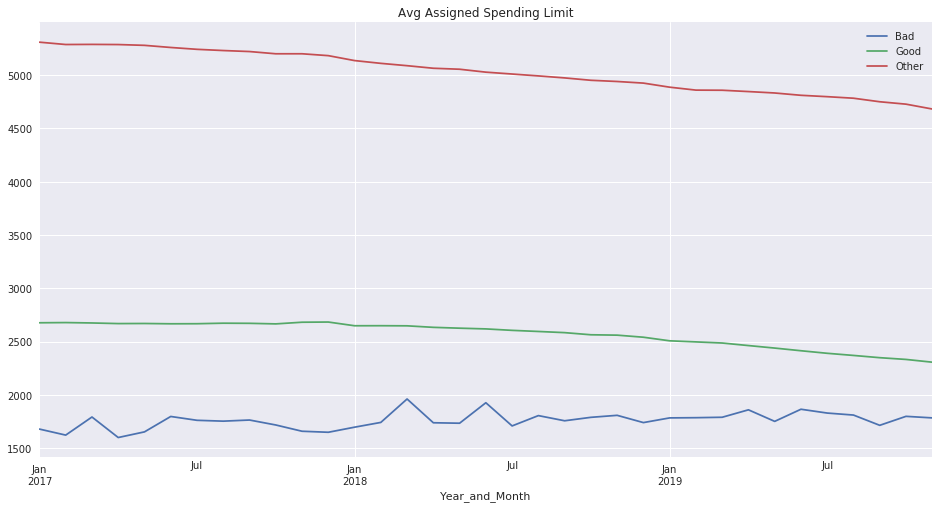

In [102]:
ax = Home_Depot_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8))
Home_Depot_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(title='Avg Assigned Spending Limit', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good','Other'])
plt.show()

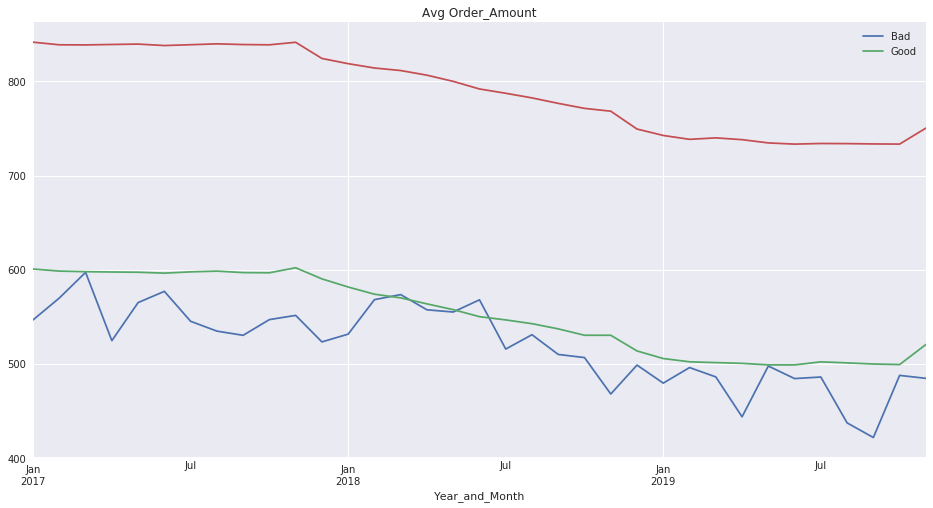

In [103]:
ax = Home_Depot_bad.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8))
Home_Depot_good.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot(title='Avg Order_Amount', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

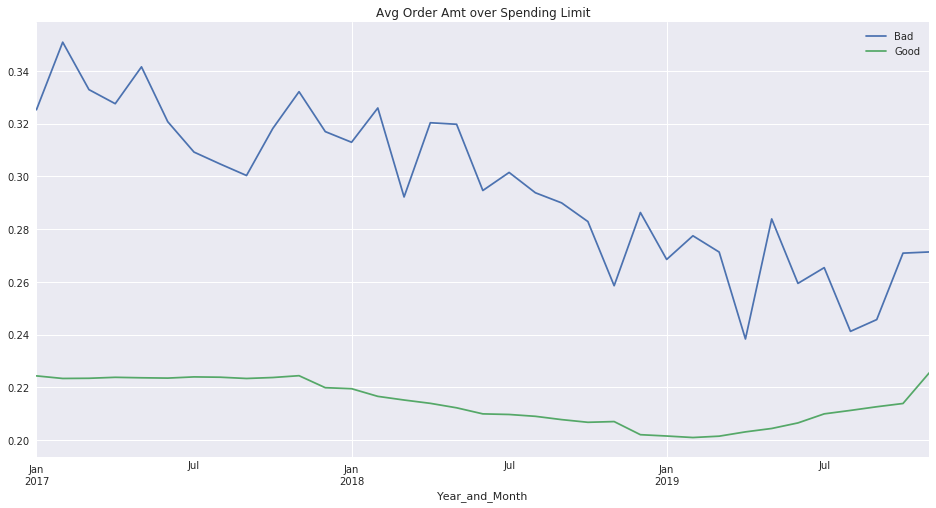

In [104]:
ax = (Home_Depot_bad.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/Home_Depot_bad.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot()

(Home_Depot_good.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/Home_Depot_good.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(title='Avg Order Amt over Spending Limit', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

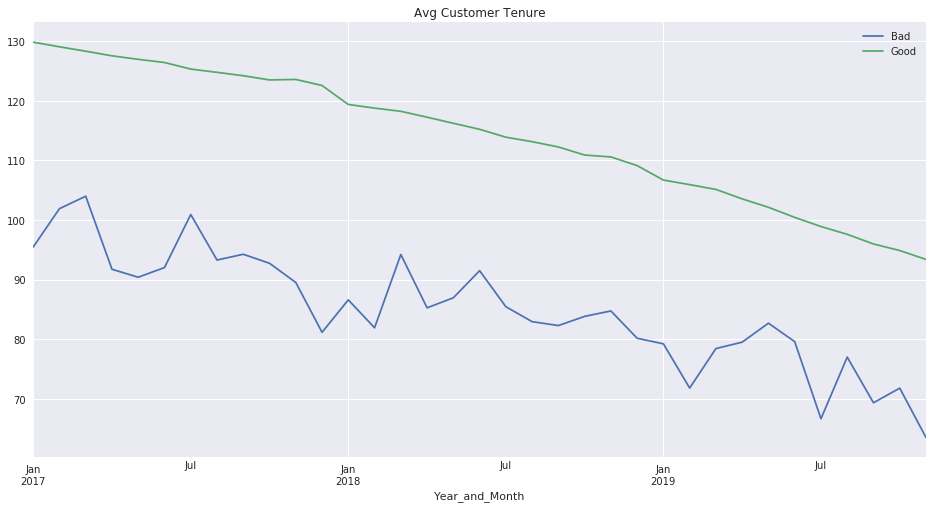

In [105]:
ax = Home_Depot_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot()
Home_Depot_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(title='Avg Customer Tenure', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

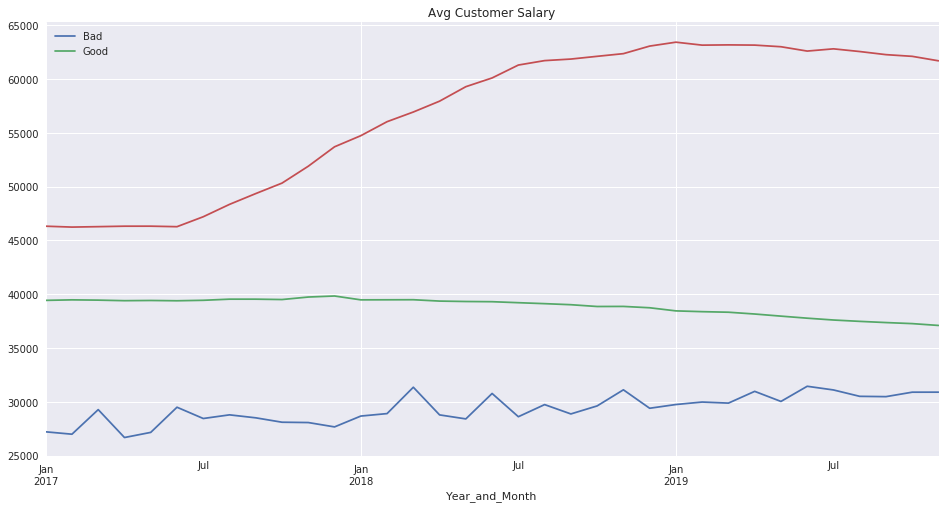

In [106]:
ax = Home_Depot_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot()
Home_Depot_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(title='Avg Customer Salary', figsize=(16, 8),ax=ax)
rest.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(title='Avg Customer Salary', figsize=(16, 8),ax=ax)
ax.legend(['Bad','Good'])
plt.show()

In [107]:
Home_Depot_bad['Status'].value_counts()

Terminated     9041
Direct Bill    4054
Employed       2088
LOA             480
Deceased         50
Name: Status, dtype: int64

				*=============================================*
				Top Loss Contribution(13) over past 3 years
				*=============================================*
*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     35
DIRECT BILL                1872
EMPLOYED                   8631
TERMINATED                    2


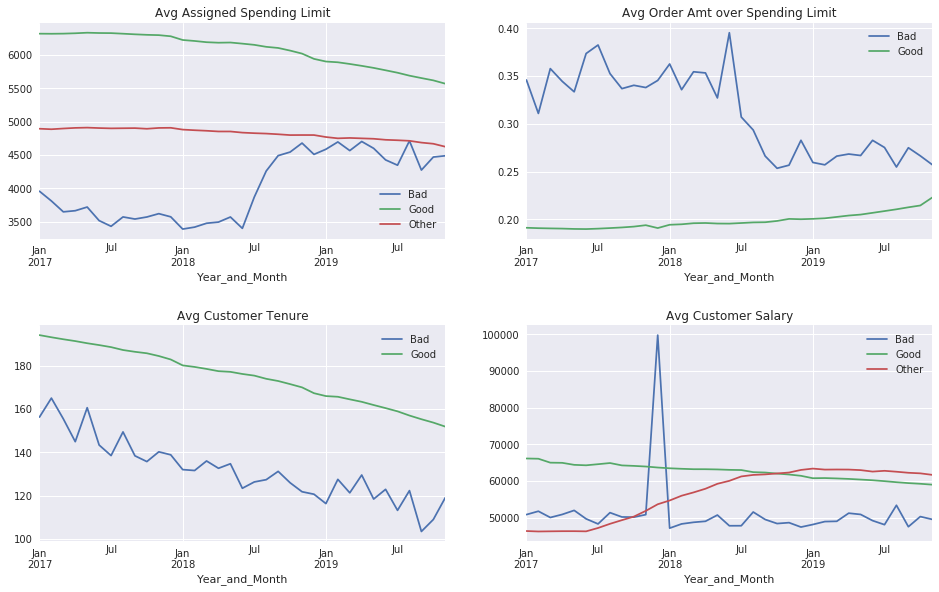

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     22
DIRECT BILL                1774
EMPLOYED                    919
LOA                         216
TERMINATED                 4077


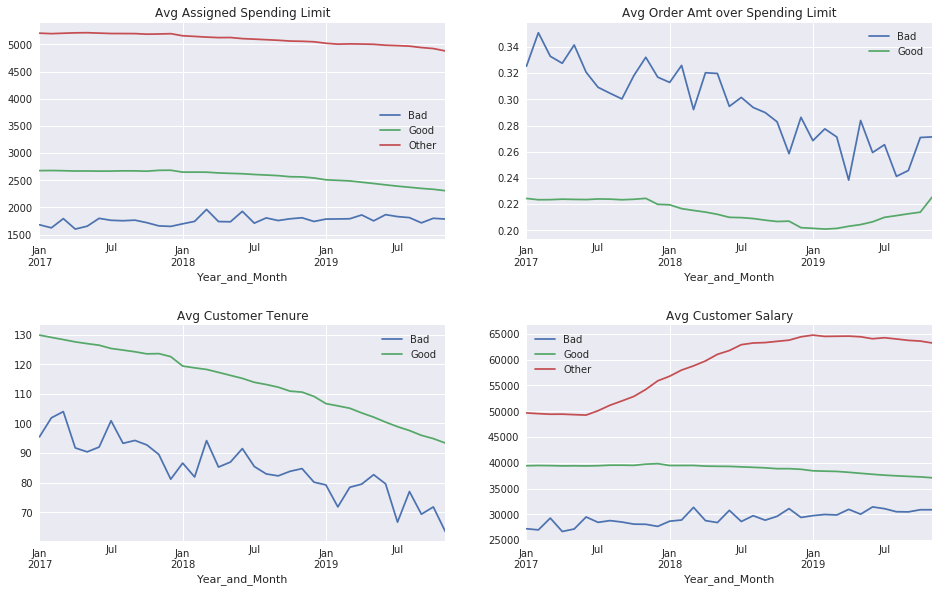

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      9
DIRECT BILL                 678
EMPLOYED                    254
LOA                          64
TERMINATED                 1758


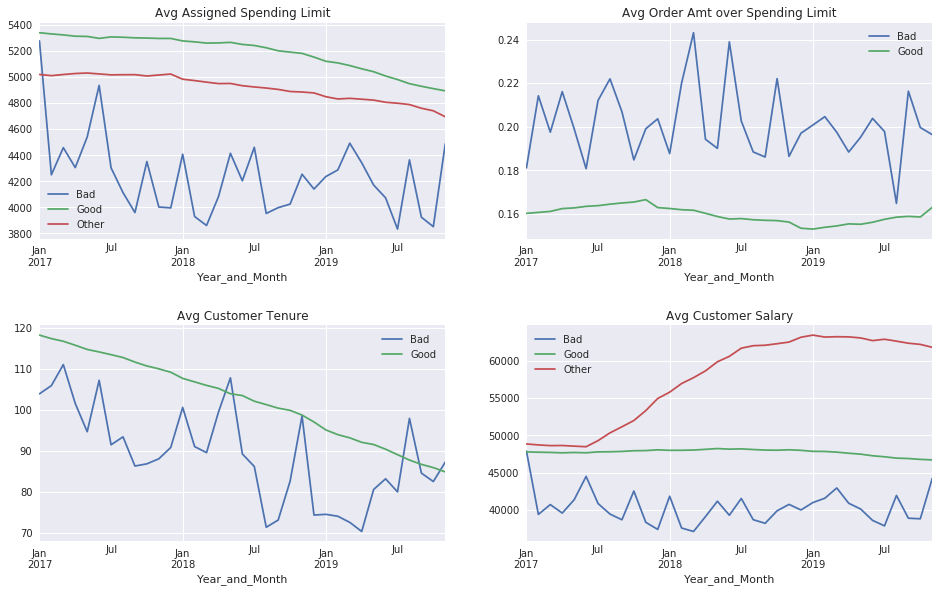

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      5
DIRECT BILL                 913
EMPLOYED                    168
LOA                         101
TERMINATED                 2051


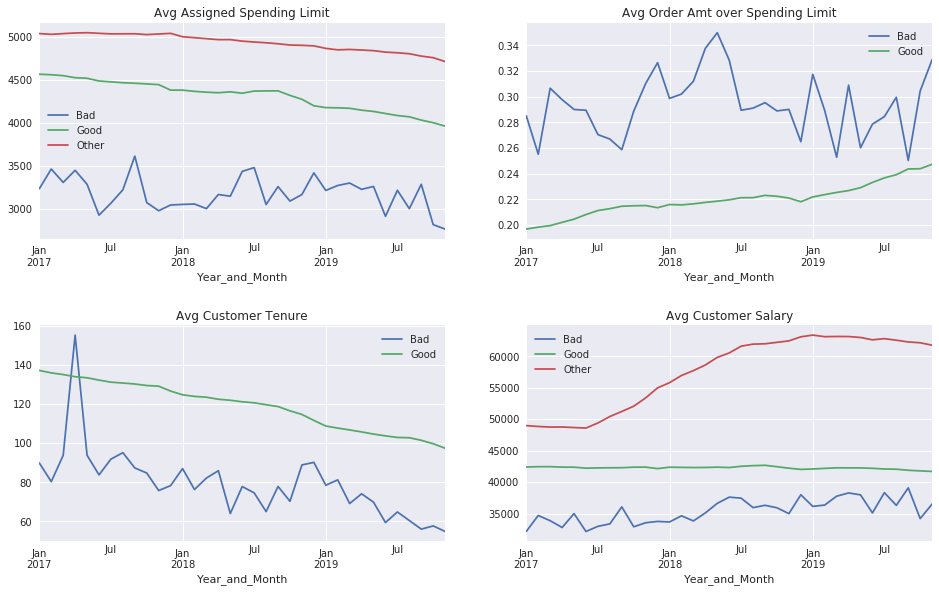

*===============================================================================================================*
						 COMMUNITY HEALTH SYSTEMS
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     13
DIRECT BILL                 639
EMPLOYED                    413
TERMINATED                 1348


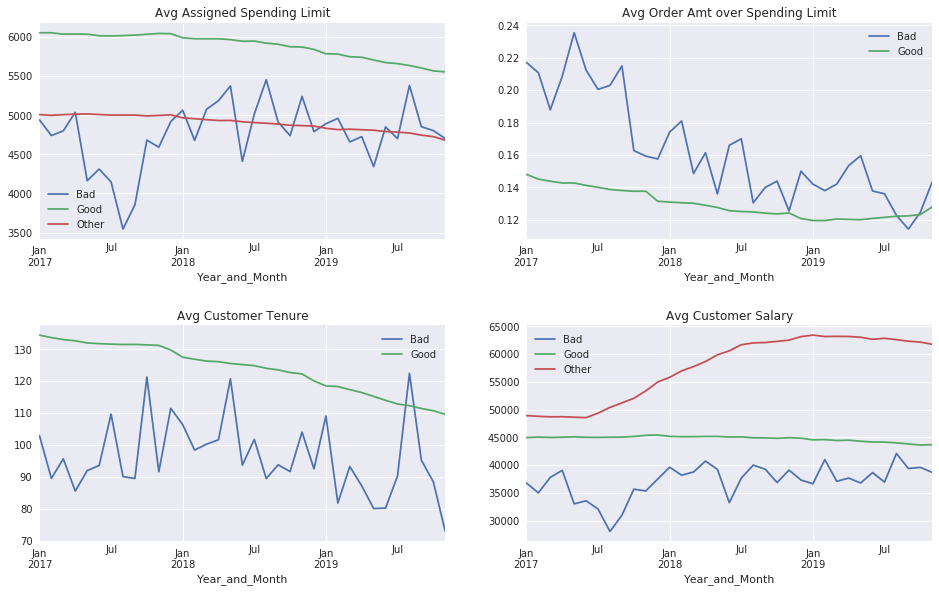

*===============================================================================================================*
						 SEANC
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     27
DIRECT BILL                 958
EMPLOYED                    121
LOA                           5
TERMINATED                  409


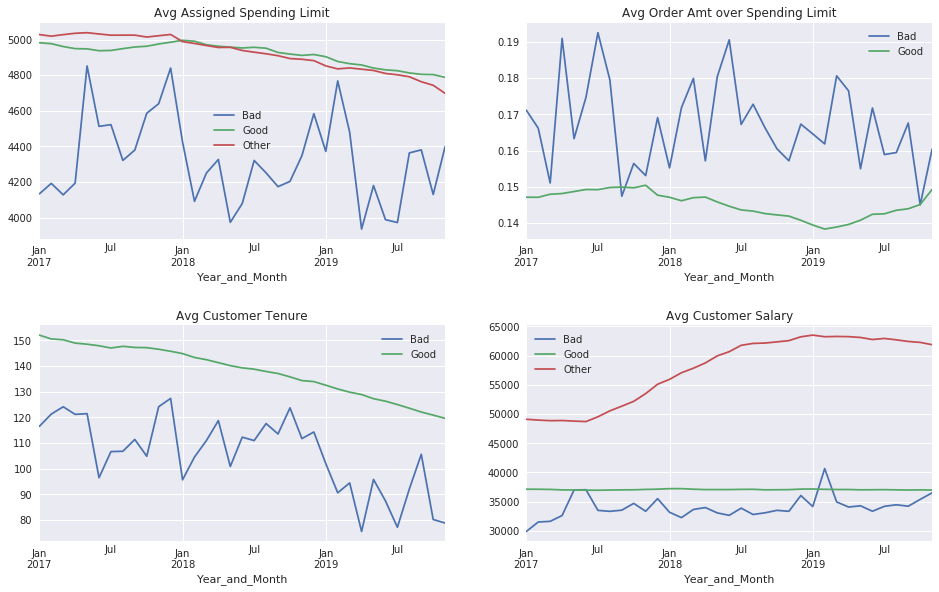

*===============================================================================================================*
						 KOHL'S DEPARTMENT STORES
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      3
DIRECT BILL                 592
EMPLOYED                     73
LOA                           1
TERMINATED                  870


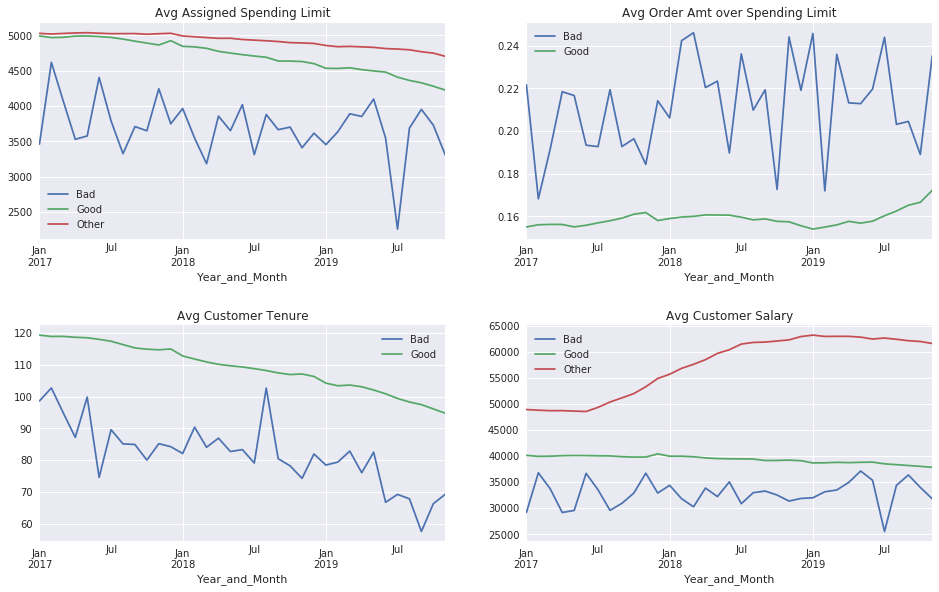

*===============================================================================================================*
						 CALIFORNIA STATE EMPLOYEES ASSOCIATION
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     10
DIRECT BILL                  22
EMPLOYED                    801


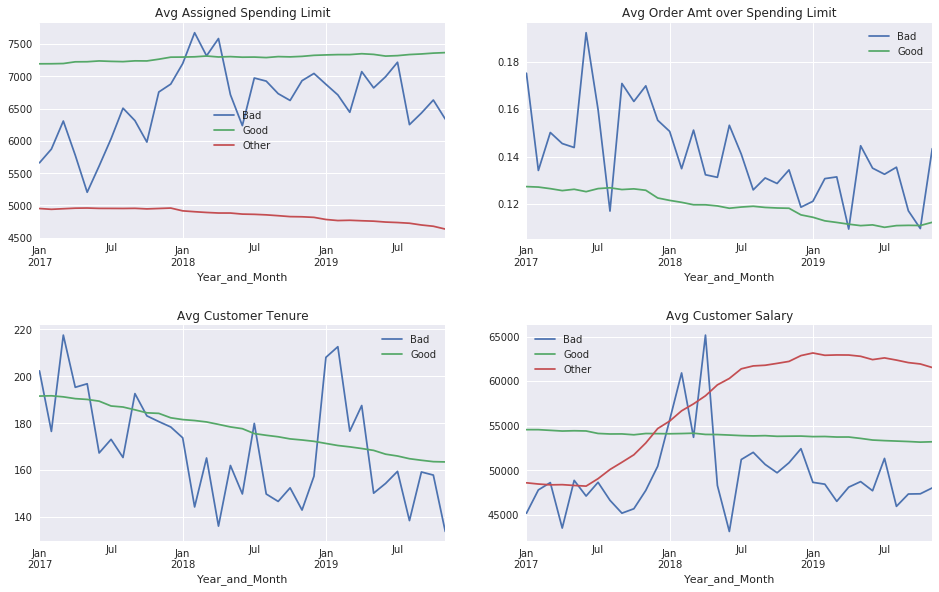

*===============================================================================================================*
						 DELTA AIR LINES, INC.
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     12
DIRECT BILL                 181
EMPLOYED                    579
LOA                         237
TERMINATED                  326


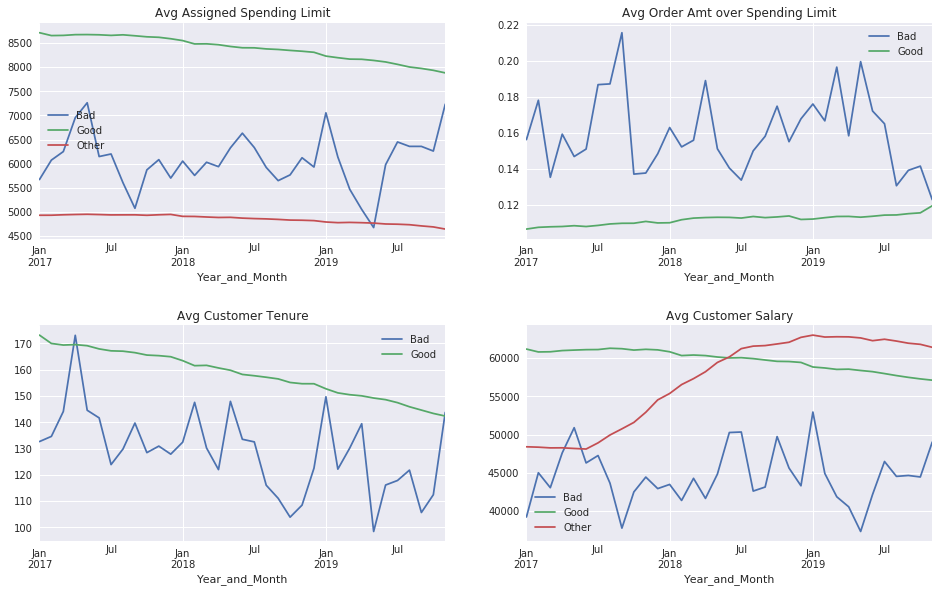

*===============================================================================================================*
						 AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      9
DIRECT BILL                 203
EMPLOYED                    768


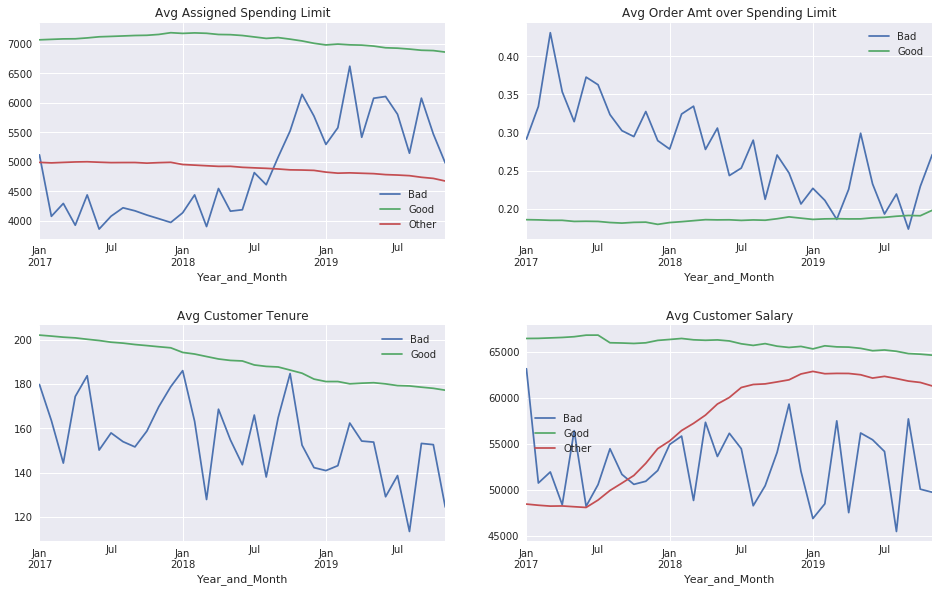

*===============================================================================================================*
						 COMPASS GROUP (NEW)
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      8
DIRECT BILL                1075
EMPLOYED                    243
LOA                           7
TERMINATED                 1064


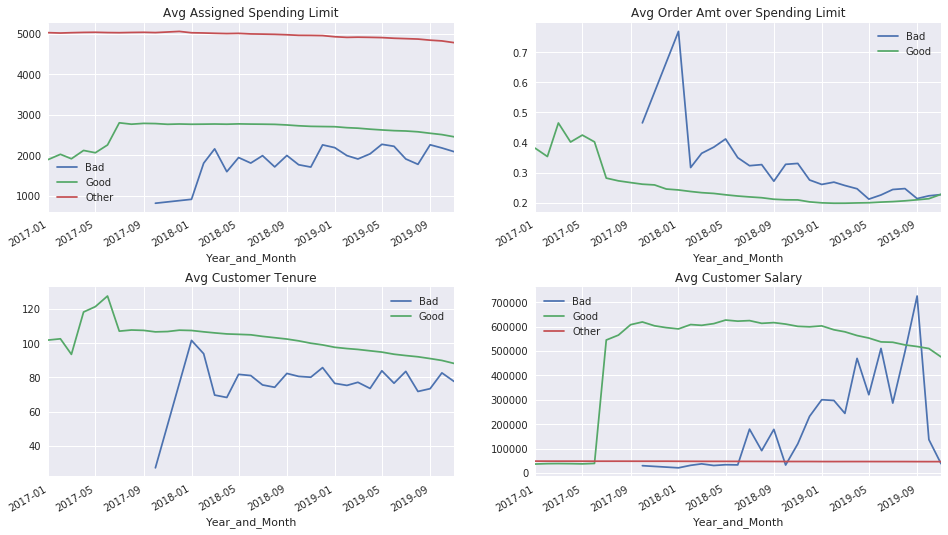

*===============================================================================================================*
						 ADVANCE AUTO PARTS, INC.
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                     13
DIRECT BILL                 756
EMPLOYED                     83
LOA                           6
TERMINATED                  647


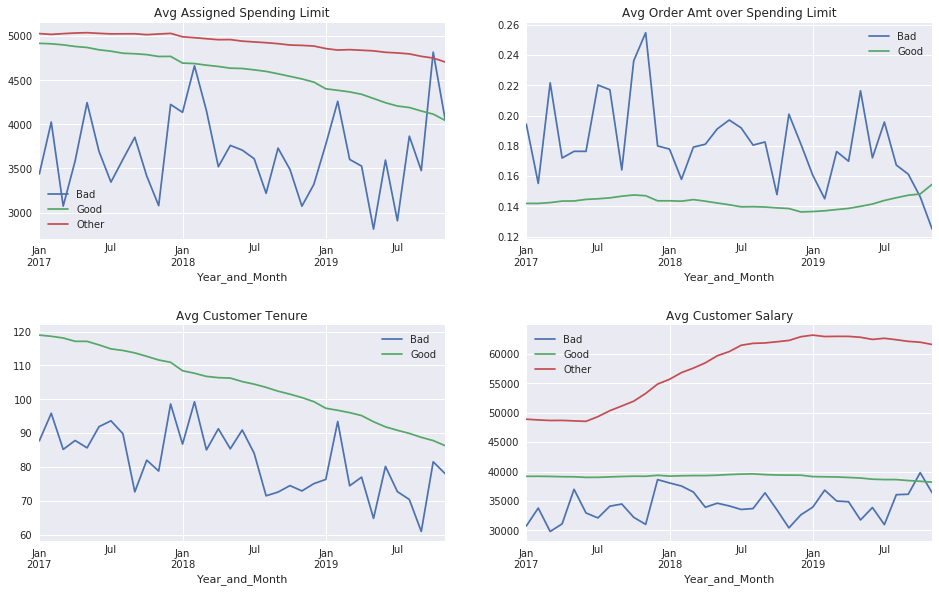

*===============================================================================================================*
						 WALGREENS FULL-TIME
*===============================================================================================================*
             Unique_Customer_ID
Status                         
DECEASED                      5
DIRECT BILL                 569
EMPLOYED                    336
LOA                          41
TERMINATED                  555


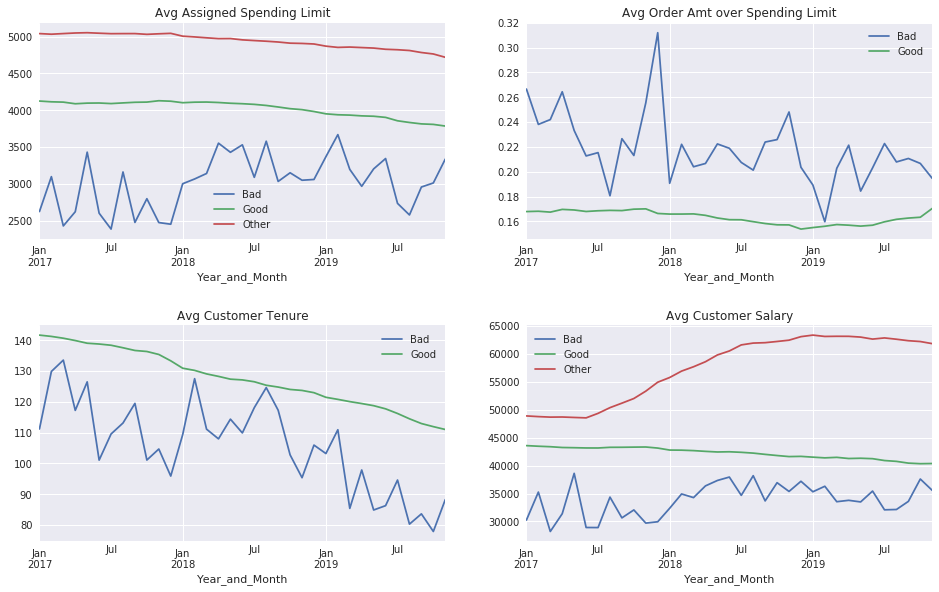

In [13]:
list_of_client_ids =[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]

print('\t\t\t\t*=============================================*')
print('\t\t\t\tTop Loss Contribution(13) over past 3 years')
print('\t\t\t\t*=============================================*')
# Client View
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.4)
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
    df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
    rest = df_17[df_17['Unique_Company_ID']!=client_id]
    acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

    df_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
    df_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
    rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax = axes[0,0])
    axes[0,0].legend(['Bad','Good','Other'])
    axes[0,0].set_title('Avg Assigned Spending Limit')
    
    (df_bad.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/df_bad.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(ax=axes[0,1])

    (df_good.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/df_good.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(ax=axes[0,1])
    axes[0,1].legend(['Bad','Good'])
    axes[0,1].set_title('Avg Order Amt over Spending Limit')
    
    df_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(ax=axes[1,0])
    df_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(ax=axes[1,0])
    axes[1,0].legend(['Bad','Good'])
    axes[1,0].set_title('Avg Customer Tenure')
    
    df_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    df_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    rest.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    axes[1,1].legend(['Bad','Good','Other'])
    axes[1,1].set_title('Avg Customer Salary')
    
    
    print(df_bad.groupby(['Status']).agg({'Unique_Customer_ID':'nunique'}))
    
    plt.show()